In [58]:
import sys
import os

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np
from tqdm import tqdm
from BuildingBlocks import Encoder, Decoder, FinalConv, DoubleConv, ExtResNetBlock, SingleConv
from unetGlcm import UNet3D
import torch.nn.functional as F
from td_attention_unet import UNet3D
#from Unet_projection_attention import UNet3DWithSwinFusion
from unetSwinGateAttention import UNet3DWithSwinGatedFusion
from UNet3DWithSkipSwinPurifier_ import UNet3DWithSkipSwinPurifier

In [60]:
print(np.__version__)

2.1.3


In [61]:
from sklearn.model_selection import train_test_split

In [62]:
TRAIN_DATASET_PATH = '/home/islam/Downloads/archive_001/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '/home/islam/Downloads/archive_001/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [63]:
import SimpleITK as sitk

In [64]:

def correct_bias_field(input_image):
    """
    Perform bias field correction on a 3D MRI image.
    
    Args:
        input_image_path (str): Path to the 3D MRI image (.nii or .nii.gz).
    
    Returns:
        sitk.Image: Bias field corrected 3D MRI image.
    """
    # Load the input image
    #raw_img_sitk = sitk.ReadImage(input_image_path, sitk.sitkFloat32)
    raw_img_sitk = sitk.GetImageFromArray(input_image)
    raw_img_sitk = sitk.DICOMOrient(raw_img_sitk, 'RPS')  # Reorient to standard
    
    # Create a head mask
    transformed = sitk.RescaleIntensity(raw_img_sitk, 0, 255)
    head_mask = sitk.LiThreshold(transformed, 0, 1)
    
    # Bias Field Correction
    shrink_factor = 4
    input_image_shrunk = sitk.Shrink(raw_img_sitk, [shrink_factor] * raw_img_sitk.GetDimension())
    mask_image_shrunk = sitk.Shrink(head_mask, [shrink_factor] * raw_img_sitk.GetDimension())
    
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_shrunk = bias_corrector.Execute(input_image_shrunk, mask_image_shrunk)
    
    # Full-resolution correction
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img_sitk)
    corrected_full_resolution = raw_img_sitk / sitk.Exp(log_bias_field)
    #corrected_full_resolution.CopyInformation(input_image)
    
    # Convert the SimpleITK image to a Numpy array
    corrected_np = sitk.GetArrayFromImage(corrected_full_resolution)
    
    # Create a NIfTI image using nibabel
    affine = np.array(corrected_full_resolution.GetDirection()).reshape(3, 3) @ np.diag(corrected_full_resolution.GetSpacing())
    origin = np.array(corrected_full_resolution.GetOrigin())
    affine = np.hstack([affine, origin[:, None]])
    affine = np.vstack([affine, [0, 0, 0, 1]])  # Add last row for affine
    
    nifti_image = nib.Nifti1Image(corrected_np, affine)
    return nifti_image

# Example usage:
# corrected_image = correct_bias_field("path_to_your_mri_image.nii.gz")
# sitk.WriteImage(corrected_image, "corrected_image.nii.gz")

In [65]:
from gibbs_removal import gibbs_removal

def gibbs_removal_nii(input_image_nii, slice_axis=2, n_points=3):
    """
    Applies Gibbs ringing removal to a .nii MRI file.

    Parameters
    ----------
    input_filepath : str
        Path to the input .nii file.
    output_filepath : str
        Path to save the corrected .nii file.
    slice_axis : int, optional
        Data axis corresponding to the number of acquired slices. Default is 2.
    n_points : int, optional
        Number of neighbor points to access local TV. Default is 3.
    """
    # Load the .nii file
    #nii = nib.load(input_image_nii)
    vol = input_image_nii.get_fdata()  # Extract data as a NumPy array
    affine = input_image_nii.affine  # Get the affine transformation matrix
    header = input_image_nii.header  # Get the header information

    # Apply Gibbs ringing removal
    corrected_vol = gibbs_removal(vol, slice_axis=slice_axis, n_points=n_points)

    # Create a new NIfTI image with the corrected data
    corrected_nii = nib.Nifti1Image(corrected_vol, affine, header)

    # Save the corrected image to the specified output file
    #nib.save(corrected_nii, output_filepath)

    #print(f"Gibbs ringing removal applied. Corrected file saved at: {output_filepath}")
    return corrected_vol


In [66]:


class BRATSDataset(Dataset):
    def __init__(self, study_dir,var):
        """
        Args:
            study_dir (str): Path to the directory containing all studies for the BRATS dataset.
        """
        self.study_dir = study_dir
        self.var = var
        # Automatically find all study IDs by listing subdirectories
        self.study_ids = sorted([d.split('_')[-1] for d in os.listdir(study_dir) if os.path.isdir(os.path.join(study_dir, d))])

    def __len__(self):
        # Return the total number of studies
        return len(self.study_ids)

    def __getitem__(self, idx):
        # Get the study ID at the given index
        study_id = self.study_ids[idx]
        # Load the study data and label
        image, label = self.load_study(study_id)
        ####label = torch.from_numpy(label).long()
        
        # Optional: Apply any data transformations (e.g., normalization) here
        # if self.transform:
        #     image, label = self.transform(image, label)
        return image, label

    def load_study(self, study_id):
        # Define file paths for each modality
        image_paths = [
            f'{self.study_dir}/BraTS20_{self.var}_{study_id}/BraTS20_{self.var}_{study_id}_t1.nii',      # T1 modality
            f'{self.study_dir}/BraTS20_{self.var}_{study_id}/BraTS20_{self.var}_{study_id}_t1ce.nii',    # T1ce modality
            f'{self.study_dir}/BraTS20_{self.var}_{study_id}/BraTS20_{self.var}_{study_id}_t2.nii',      # T2 modality
            f'{self.study_dir}/BraTS20_{self.var}_{study_id}/BraTS20_{self.var}_{study_id}_flair.nii'    # FLAIR modality
        ]
        label_path = f'{self.study_dir}/BraTS20_{self.var}_{study_id}/BraTS20_{self.var}_{study_id}_seg.nii'  # Segmentation label

        # Load each modality and stack into a 4-channel tensor
        modalities = [nib.load(img_path).get_fdata().astype(np.float32) for img_path in image_paths]
        modalities_cropped = []
        for modality in modalities:
            #numpy_array = modality.get_fdata()
            #modality = correct_bias_field(modality)
            #modality = gibbs_removal_nii(modality, slice_axis=2, n_points=3)
            depth = modality.shape[2]  # Get depth (3rd dimension)
            center = depth // 2  # Center slice
            start = 46  # Starting index for 11 slices
            end = 109  # Ending index for 11 slices (inclusive)
            modalities_cropped.append(modality)
        image = np.stack(modalities, axis=0)  # Shape: [4, depth, height, width]
        label_path = f'{self.study_dir}/BraTS20_{self.var}_{study_id}/BraTS20_{self.var}_{study_id}_seg.nii'  # Segmentation label


        # Load the segmentation label
        #image = nib.load(image_paths[3]).get_fdata().astype(np.int32) 
        label = nib.load(label_path).get_fdata().astype(np.float32)  # Shape: [depth, height, width]
        #label = label[:, :, 46:109]
        label[label == 4] = 3
        print(f"Label range: {label.min().item()} to {label.max().item()}")
        #label = label.long()
        return image, label

In [67]:
# Training function
'''
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)
'''
# For PyTorch 2.x (latest style)# For PyTorch 2.x AMP
from torch.amp import autocast, GradScaler

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    scaler = GradScaler()

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).long()

        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs= model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device).long()

            with autocast(device_type='cuda', dtype=torch.float16):  # use AMP in validation too
                outputs= model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item()

    return running_loss / len(val_loader)



In [68]:
torch.cuda.empty_cache()

In [69]:
def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1} to {path}")

def load_checkpoint(model, optimizer, path="checkpoint.pth"):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'],strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch+1}")
        return start_epoch
    else:
        print(f"No checkpoint found at {path}. Starting from scratch.")
        return 0


In [70]:
device = torch.cuda.current_device()    
total_memory = torch.cuda.get_device_properties(device).total_memory
reserved_memory = torch.cuda.memory_reserved(device)
allocated_memory = torch.cuda.memory_allocated(device)
free_memory = reserved_memory - allocated_memory

print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Reserved GPU Memory: {reserved_memory / (1024 ** 3):.2f} GB")
print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")

Total GPU Memory: 23.59 GB
Reserved GPU Memory: 9.21 GB
Allocated GPU Memory: 9.16 GB
Free GPU Memory: 0.05 GB


In [71]:
# Load data]
train_dataset = BRATSDataset(study_dir=TRAIN_DATASET_PATH, var='Training')
#print(len(train_dataset.study_ids))
#print(train_dataset.study_ids)
all_ids = train_dataset.study_ids
#train_test_ids, val_ids = train_test_split(all_ids,test_size=0.2) 
#train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)
train_ids=['192', '136', '014', '191', '294', '235', '026', '150', '131', '144', '022', '018', '115', '210', '053', '273', '176', '352', '020', '359', '309', 
           '123', '264', '160', '149', '348', '260', '369', '182', '122', '366', '238', '230', '248', '322', '029', '221', '339', '145', '031', '334', '263', 
           '279', '007', '038', '074', '025', '347', '002', '127', '280', '082', '064', '172', '362', '114', '231', '043', '165', '278', '016', '197', '067', 
           '307', '331', '200', '203', '344', '346', '327', '089', '275', '178', '059', '300', '008', '017', '284', '224', '297', '218', '351', '019', '096', 
           '283', '036', '336', '075', '311', '360', '308', '081', '320', '364', '277', '342', '292', '316', '057', '243', '032', '179', '356', '217', '326', 
           '125', '232', '048', '242', '285', '170', '132', '139', '291', '164', '233', '054', '035', '215', '196', '357', '202', '324', '254', '270', '133', 
           '183', '350', '046', '162', '343', '073', '288', '173', '228', '214', '166', '213', '009', '353', '298', '319', '141', '155', '129', '241', '257', 
           '072', '256', '239', '249', '027', '229', '159', '094', '110', '174', '108', '318', '253', '281', '119', '024', '113', '194', '068', '041', '177', 
           '306', '310', '290', '272', '120', '042', '367', '187', '354', '154', '104', '087', '330', '091', '258', '338', '188', '088', '321', '341', '340', 
           '045', '169', '227', '148', '325', '086', '286', '153', '247', '050', '167', '199', '212', '021', '085', '315', '274', '333', '006', '109', '299', 
           '100', '034', '077', '083', '246', '101', '328', '126', '049', '295', '195', '220', '137', '152', '244', '175', '223', '013', '063', '102', '304', 
           '361', '205', '066', '023', '158', '234', '084', '180', '240', '001', '058', '118', '337', '030', '282', '103', '156', '116', '143']

test_ids=['117', '216', '313', '171', '190', '293', '365', '012', '266', '252', '040', '236', '004', '128', '301', '015', '245', '011', '204', '314', '161', 
          '047', '051', '157', '358', '186', '289', '044', '181', '261', '037', '265', '105', '302', '317', '209', '039', '106', '355', '093', '198', '095', 
          '134', '076', '312']
val_ids= ['255', '349', '135', '193', '323', '168', '219', '185', '010', '250', '335', '251', '065', '080', '267', '206', '124', '363', '303', '005', '146', 
          '056', '142', '140', '329', '268', '092', '201', '097', '269', '147', '071', '090', '211', '151', '070', '078', '112', '207', '296', '062', '271', 
          '111', '259', '060', '189', '345', '130', '226', '225', '287', '138', '028', '052', '237', '003', '098', '033', '069', '262', '184', '099', '208', 
          '276', '121', '055', '368', '305', '163', '061', '107', '222', '079', '332']
val_dataset = BRATSDataset(study_dir=TRAIN_DATASET_PATH, var='Training')
val_dataset.study_ids = val_ids
train_dataset.study_ids = train_ids
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

train_losses = []
val_losses = []

In [72]:
class MultiClassFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (float, list, or Tensor): Weighting factor for each class. If a single float is provided,
                                              it is used for all classes. If a list or Tensor of shape (C,)
                                              is provided, each class is weighted accordingly.
            gamma (float): Focusing parameter. Defaults to 2.0.
            reduction (str): 'mean', 'sum', or 'none'. Defaults to 'mean'.
        """
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Logits tensor of shape (N, C, D, H, W).
            targets: Ground truth tensor of shape (N, D, H, W) with class indices (0, 1, ..., C-1).
        """
        # Compute log softmax and probabilities
        log_probs = F.log_softmax(inputs, dim=1)  # (N, C, D, H, W)
        probs = torch.exp(log_probs)
        
        # Gather log probabilities and probabilities corresponding to targets
        targets = targets.long()
        log_pt = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)  # (N, D, H, W)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)          # (N, D, H, W)
        
        # If alpha is provided, get the weights for the true classes
        if self.alpha is not None:
            if isinstance(self.alpha, (list, tuple)):
                alpha_tensor = torch.tensor(self.alpha, device=inputs.device)
            else:
                alpha_tensor = self.alpha
            alpha_factor = alpha_tensor[targets]
        else:
            alpha_factor = 1.0

        # Compute the focal loss
        focal_loss = -alpha_factor * (1 - pt) ** self.gamma * log_pt
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [73]:
def compute_class_weights(device,dataset, num_classes=4):
    """
    Compute class weights based on the inverse frequency of each class.
    """
    class_counts = np.zeros(num_classes)

    for ids in train_ids:  # Iterate through dataset to count labels
        _,label = dataset.load_study(ids)
        label = label.to(device)
        label = label.cpu().numpy()
        unique, counts = np.unique(label.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[u] += c  # Accumulate pixel counts per class

    class_weights = 1.0 / (class_counts + 1e-6)  # Avoid division by zero
    class_weights /= class_weights.sum()  # Normalize weights

    return torch.tensor(class_weights, dtype=torch.float32)

In [74]:
import torch

def gradient_magnitude_3d(prob):
    """
    Computes the average 3D gradient magnitude of a multi-class probability map.
    prob: (N, C, D, H, W) after softmax or sigmoid.
    
    Returns:
        scalar tensor (the mean gradient magnitude over all batches, channels, and voxels).
    """
    # prob is float tensor
    # We'll compute finite differences along D, H, W for each channel.

    # D-direction differences (shape: (N, C, D-1, H, W))
    d_diff = prob[:, :, 1:, :, :] - prob[:, :, :-1, :, :]
    # H-direction differences (shape: (N, C, D, H-1, W))
    h_diff = prob[:, :, :, 1:, :] - prob[:, :, :, :-1, :]
    # W-direction differences (shape: (N, C, D, H, W-1))
    w_diff = prob[:, :, :, :, 1:] - prob[:, :, :, :, :-1]

    # Square them
    d_sq = d_diff**2
    h_sq = h_diff**2
    w_sq = w_diff**2

    # We need to match shapes before summing. One approach:
    #   - For d_diff we lose 1 slice in the D dimension
    #   - For h_diff we lose 1 slice in the H dimension
    #   - For w_diff we lose 1 slice in the W dimension
    # We'll sum up the valid overlapping region. For simplicity,
    # we can just center-crop the others to match the smallest shape (D-1, H-1, W-1).
    # Alternatively, you can compute separate means and then average.
    # Here, let's do a simpler approach: compute each mean individually and then average.
    d_mag = torch.sqrt(d_sq + 1e-8)
    h_mag = torch.sqrt(h_sq + 1e-8)
    w_mag = torch.sqrt(w_sq + 1e-8)

    # Mean of each
    d_mean = torch.mean(d_mag)
    h_mean = torch.mean(h_mag)
    w_mean = torch.mean(w_mag)

    # Overall average
    grad_mag = (d_mean + h_mean + w_mean) / 3.0
    return grad_mag

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassAdaptiveFocalLoss(nn.Module):
    """
    Multi-class Adaptive Focal Loss (A-FL) for 3D segmentation.
    
    Extends your existing multi-class focal loss to incorporate:
      - Volume-based parameter alpha_v
      - Mean surface smoothness gamma_ms
      - Adaptive exponent: gamma_adaptive = gamma + alpha_v * gamma_ms
    """
    def __init__(self, 
                 alpha=None, 
                 gamma=2.0, 
                 reduction='mean',
                 background_class=0):
        """
        Args:
            alpha (float, list, or Tensor): Class weighting factor. 
                If float, used for all classes; if list/Tensor of shape (C,), each class is weighted.
            gamma (float): Base focusing parameter (default=2.0).
            reduction (str): 'mean', 'sum', or 'none' (default='mean').
            background_class (int): Index of the background class (default=0).
        """
        super(MultiClassAdaptiveFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.background_class = background_class

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Logits tensor of shape (N, C, D, H, W).
            targets: Ground truth of shape (N, D, H, W), with class indices in [0, C-1].
        Returns:
            Scalar (if reduction='mean'/'sum') or Tensor (if reduction='none').
        """
        # 1) Convert logits -> log_probs and probs via softmax
        log_probs = F.log_softmax(inputs, dim=1)       # (N, C, D, H, W)
        probs = torch.exp(log_probs)                   # (N, C, D, H, W)

        # 2) Gather log_probs & probs corresponding to the target class at each voxel
        targets = targets.long()                       # Ensure long dtype
        log_pt = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)  # (N, D, H, W)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)          # (N, D, H, W)

        # 3) If alpha is provided, use per-class or scalar weighting
        if self.alpha is not None:
            if isinstance(self.alpha, (list, tuple)):
                alpha_tensor = torch.tensor(self.alpha, device=inputs.device, dtype=inputs.dtype)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_tensor = self.alpha.to(inputs.device)
            else:
                # scalar float
                alpha_tensor = torch.tensor([self.alpha]*probs.size(1), device=inputs.device, dtype=inputs.dtype)
            
            # alpha_factor shape: (N, D, H, W)
            alpha_factor = alpha_tensor[targets]
        else:
            alpha_factor = 1.0

        # ---------------------------------------------------------------
        # 4) Compute alpha_v (volume-based parameter)
        #    Example approach: treat `background_class` as background 
        #    and everything else as "foreground." 
        #    alpha_v = #foreground_voxels / (#foreground_voxels + #background_voxels)
        # ---------------------------------------------------------------
        with torch.no_grad():
            # Count how many voxels belong to background_class
            background_mask = (targets == self.background_class)
            P_b = background_mask.sum().float()

            # Everything else is foreground
            P_f = (targets != self.background_class).sum().float()

            # alpha_v in [0, 1]
            alpha_v = P_f / (P_f + P_b + 1e-8)

        # ---------------------------------------------------------------
        # 5) Compute gamma_ms (mean surface smoothness) in 3D
        #    We can compute the gradient magnitude across all classes 
        #    or focus on certain classes. For simplicity, let's do all.
        # ---------------------------------------------------------------
        gamma_ms = gradient_magnitude_3d(probs)

        # ---------------------------------------------------------------
        # 6) Compute adaptive gamma
        #    gamma_adaptive = gamma + alpha_v * gamma_ms
        # ---------------------------------------------------------------
        gamma_adaptive = self.gamma + alpha_v * gamma_ms

        # ---------------------------------------------------------------
        # 7) Compute the standard focal loss but with gamma_adaptive
        #    focal_loss = - alpha_factor * (1 - pt)^gamma_adaptive * log_pt
        # ---------------------------------------------------------------
        focal_term = (1 - pt).pow(gamma_adaptive)
        loss = - alpha_factor * focal_term * log_pt  # shape (N, D, H, W)

        # 8) Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [76]:
# Main function
def main():
    # Parameters
    in_channels = 4  # BRATS has 4 modalities (FLAIR, T1, T1Gd, T2)
    out_channels = 4  # Number of segmentation classes
    final_sigmoid = False
    learning_rate = 1e-4
    num_epochs = 61
    batch_size = 1
    checkpoint_path = "checkpoint_epoch_61.pth"  # File path for checkpoint

    # Paths to BRATS2020 dataset
    # images_dir = "/path/to/brats2020/images"  # replace with actual path
    # labels_dir = "/path/to/brats2020/labels"  # replace with actual path
    # Device
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = BRATSDataset(study_dir=TRAIN_DATASET_PATH, var='Training')
    train_dataset.study_ids=all_ids
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    '''
    class_counts = np.zeros(4)
    for idx, (images, label) in enumerate(train_loader):
        label = label.to(device)
        label = label.cpu().numpy()
        unique, counts = np.unique(label, return_counts=True)
        for u, c in zip(unique, counts):
            u = int(u)
            class_counts[u] += c  # Accumulate pixel counts per class

    class_weights = 1.0 / (class_counts + 1e-6)  # Avoid division by zero
    class_weights /= class_weights.sum()  # Normalize weights
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    #class_weights = compute_class_weights(device,train_dataset, num_classes=4)
    class_weights = class_weights.to("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Class Weights: {class_weights}")
    '''
    # Initialize model
    '''
    model = UNet3D(in_channels=in_channels, out_channels=out_channels, final_sigmoid=final_sigmoid)
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    #criterion = MultiClassAdaptiveFocalLoss(alpha=class_weights, gamma=2.0, reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    '''
    # Initialize model
    
    '''
    base_unet3d = UNet3D(
    in_channels=in_channels,
    out_channels=out_channels,
    final_sigmoid=final_sigmoid
    )

    model = UNet3DWithSwinGatedFusion(
    base_unet3d=base_unet3d,
    out_channels=out_channels,
    swin_embed_dim=96
    )
    '''



    model = UNet3DWithSkipSwinPurifier(
    in_channels=in_channels,
    out_channels=out_channels,
    f_maps=16,
    final_sigmoid=False,
    swin_embed_dim=96
    )

    #model = UNet3D(in_channels=4, out_channels=4, final_sigmoid=False, use_glcm=True, use_se=True)

    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    # Load checkpoint if available
    start_epoch = load_checkpoint(model, optimizer, path=checkpoint_path)

    # Load data

    #train_test_ids, val_ids = train_test_split(all_ids,test_size=0.2) 
    #train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)
    val_dataset = BRATSDataset(study_dir=TRAIN_DATASET_PATH, var='Training')
    val_dataset.study_ids = val_ids
    train_dataset.study_ids = train_ids
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # Initialize lists to store loss values
    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        allocated_memory = torch.cuda.memory_allocated(device)
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        print(f"Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)  # Track training loss
        val_loss = validate_model(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}")
        val_losses.append(val_loss)  # Track validation loss
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        if epoch%2==0:
            save_checkpoint(model, optimizer, epoch, path=checkpoint_path)
if __name__ == "__main__":
    main()

No checkpoint found at checkpoint_epoch_61.pth. Starting from scratch.
Epoch 1/61


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Label range: 0.0 to 3.0


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 192]

In [ ]:
print(len(train_losses))

1


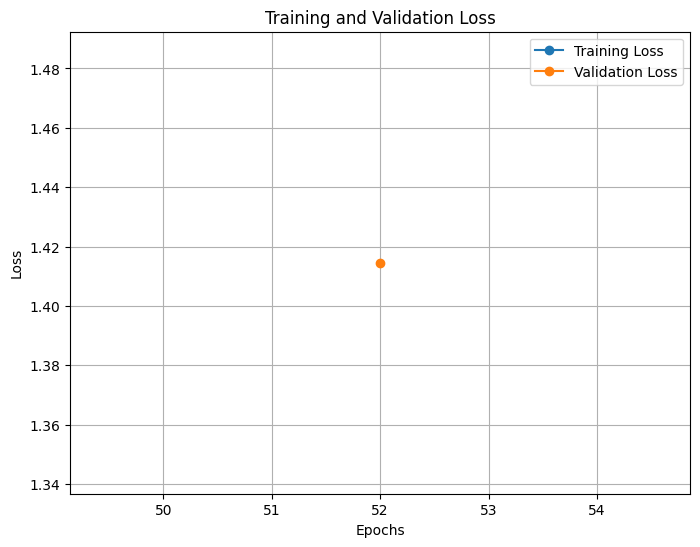

In [ ]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1+51, len(train_losses) + 1+51)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('loss_plot3.png', dpi=300)  # Save as PNG with high resolution

# Show the plot
plt.show()


In [ ]:
import numpy as np

def plot_3d_segmentation(segmentation, axis='axial', num_slices=10):
    """
    Plots slices of a 3D segmentation.

    Args:
        segmentation (numpy.ndarray): 3D array of segmentation (e.g., [H, W, D]).
        axis (str): Axis along which to slice ('axial', 'sagittal', 'coronal').
        num_slices (int): Number of slices to visualize.
    """
    # Get the shape of the segmentation
    height, width, depth = segmentation.shape

    # Select axis for slicing
    if axis == 'axial':  # Depth (transverse slices)
        slice_indices = np.linspace(0, depth - 1, num_slices, dtype=int)
        slice_title = "Axial Slice"
    elif axis == 'sagittal':  # Width
        slice_indices = np.linspace(0, width - 1, num_slices, dtype=int)
        slice_title = "Sagittal Slice"
    elif axis == 'coronal':  # Height
        slice_indices = np.linspace(0, height - 1, num_slices, dtype=int)
        slice_title = "Coronal Slice"
    else:
        raise ValueError("Invalid axis! Choose from 'axial', 'sagittal', 'coronal'.")

    # Plot each slice
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices, i + 1)
        if axis == 'axial':
            plt.imshow(segmentation[:, :, idx], cmap='viridis')  # Axial slice
        elif axis == 'sagittal':
            plt.imshow(segmentation[:, idx, :], cmap='viridis')  # Sagittal slice
        elif axis == 'coronal':
            plt.imshow(segmentation[idx, :, :], cmap='viridis')  # Coronal slice
        plt.axis('off')
        plt.title(f"{slice_title} {idx}")
    
    plt.tight_layout()
    plt.show()

# Example Usage
# predicted_segmentation is your 3D numpy array
#plot_3d_segmentation(predicted_segmentation, axis='axial', num_slices=10)
def calculate_metrics(predicted_segmentation, ground_truth_segmentation, num_classes=4):
    """
    Calculate IoU, Dice score, and volume for each class.

    Args:
        predicted_segmentation (numpy.ndarray): Predicted 3D segmentation array.
        ground_truth_segmentation (numpy.ndarray): Ground truth 3D segmentation array.
        num_classes (int): Number of segmentation classes.

    Returns:
        metrics (dict): Dictionary containing IoU, Dice, and volume for each class.
    """
    metrics = {}

    for cls in range(0, num_classes):  # Skip background (assumed as class 0)
        pred_cls = (predicted_segmentation == cls)  # Binary mask for the predicted class
        gt_cls = (ground_truth_segmentation == cls)  # Binary mask for the ground truth class

        # Calculate Intersection and Union
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()

        # IoU
        iou = intersection / union if union > 0 else 0

        # Dice Score
        dice = (2 * intersection) / (pred_cls.sum() + gt_cls.sum()) if (pred_cls.sum() + gt_cls.sum()) > 0 else 0

        # Volume (in number of voxels)
        volume = gt_cls.sum()-pred_cls.sum()

        # Store metrics
        metrics[f'class_{cls}'] = {
            'IoU': iou,
            'Dice': dice,
            'Volume': volume,
        }

    return metrics


In [ ]:
'''

test_dataset = BRATSDataset(study_dir=TRAIN_DATASET_PATH, var='Training')
test_dataset.study_ids = test_ids
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
output_dir = "segmented_outputs/"
# List all checkpoints you want to evaluate
checkpoint_epochs = list(range(29, 102, 2))  # [29, 31, 33, ..., 101]
checkpoint_epochs = [e for e in checkpoint_epochs if e % 2 != 0]  # Odd ones (29, 35, 41, ...)

for epoch in checkpoint_epochs:
    checkpoint_path = f"checkpoint_epoch_{epoch}.pth"
    
    print(f"\n\n==== Evaluating checkpoint: {checkpoint_path} ====\n")
    
    # Initialize model
    b_model = UNet3D(in_channels=4, out_channels=4, final_sigmoid=False)
    model = UNet3DWithSwinGatedFusion(
    base_unet3d=b_model,
    out_channels=4,
    swin_embed_dim=96
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    # Initialize metrics
    class_metrics = {cls: {"IoU": 0.0, "Dice": 0.0, "Volume": 0.0} for cls in range(0, 4)}
    class0, class1, class2, class3 = [], [], [], []

    with torch.no_grad():
        for idx, (images, label) in enumerate(test_loader):
            images = images.to(device)
            label = label.to(device)
            outputs= model(images)
            predicted_segmentation = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
            ground_truth_segmentation = label.cpu().numpy()

            metrics = calculate_metrics(predicted_segmentation, ground_truth_segmentation)

            voxel_volume_cm3 = 1 / 1000.0

            for cls in range(4):
                class_metrics[cls]["IoU"] += metrics[f"class_{cls}"]["IoU"]
                class_metrics[cls]["Dice"] += metrics[f"class_{cls}"]["Dice"]
                class_metrics[cls]["Volume"] += metrics[f"class_{cls}"]["Volume"] * voxel_volume_cm3

                # For individual sample Dice
                if cls == 0:
                    class0.append(metrics["class_0"]["Dice"])
                if cls == 1:
                    class1.append(metrics["class_1"]["Dice"])
                if cls == 2:
                    class2.append(metrics["class_2"]["Dice"])
                if cls == 3:
                    class3.append(metrics["class_3"]["Dice"])

            np.save(os.path.join(output_dir, f"segmented_{epoch}_{idx}.npy"), predicted_segmentation)

    # Average over all test samples
    for cls in range(4):
        class_metrics[cls]["IoU"] /= len(test_ids)
        class_metrics[cls]["Dice"] /= len(test_ids)
        class_metrics[cls]["Volume"] /= len(test_ids)

    print(f"==== Results for checkpoint {epoch} ====")
    for cls, values in class_metrics.items():
        print(f"Class {cls}: IoU = {values['IoU']:.4f}, Dice = {values['Dice']:.4f}, Avg Volume = {values['Volume']:.2f} voxels")



'''



==== Evaluating checkpoint: checkpoint_epoch_29.pth ====



/tmp/ipykernel_10110/3263628642.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


NameError: name 'test_loader' is not defined

In [ ]:
test_dataset = BRATSDataset(study_dir=TRAIN_DATASET_PATH, var='Training')
test_dataset.study_ids = test_ids
class0=[]
class1=[]
class2=[]
class3=[]
model = UNet3DWithSkipSwinPurifier(
    in_channels=4,
    out_channels=4,
    f_maps=16,
    final_sigmoid=False,
    swin_embed_dim=96
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
output_dir = "segmented_outputs/"
os.makedirs(output_dir, exist_ok=True)
class_metrics = {
    cls: {"IoU": 0.0, "Dice": 0.0, "Volume": 0.0} 
    for cls in range(0,4)  # Assuming num_classes is defined
}
with torch.no_grad():  # Disable gradient calculation for inference
    for idx, (images, label) in enumerate(test_loader):  
        images = images.to(device)
        label = label.to(device)
        # Forward pass
        outputs = model(images)
        #plot_3d_segmentation(predicted_segmentation, axis='axial', num_slices=10)
        # Get predicted segmentation (argmax to convert probabilities to class indices)
        predicted_segmentation = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Shape: [H, W, D]
        ground_truth_segmentation = label.cpu().numpy()
        metrics = calculate_metrics(predicted_segmentation, ground_truth_segmentation)
        # Accumulate metrics
        #for p in range(0,3):
        # Get voxel spacing (in mm)
        #nii = nib.load(r'home/islam/Downloads/archive_001/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')
        #voxel_spacing = nii.header.get_zooms()  # Returns (spacing_x, spacing_y, spacing_z)
        #voxel_volume_mm3 = voxel_spacing[0] * voxel_spacing[1] * voxel_spacing[2]  # mm³
    
        # Convert voxel volume to cm³
        voxel_volume_cm3 = 1 / 1000.0  # mm³ to cm³
        class_metrics[0]["IoU"] += metrics["class_0"]["IoU"]
        class_metrics[0]["Dice"] += metrics["class_0"]["Dice"]
        class_metrics[0]["Volume"] += metrics["class_0"]["Volume"]*voxel_volume_cm3
        class0.append(metrics["class_0"]["Dice"])


        class_metrics[1]["IoU"] += metrics["class_1"]["IoU"]
        class_metrics[1]["Dice"] += metrics["class_1"]["Dice"]
        class_metrics[1]["Volume"] += metrics["class_1"]["Volume"]*voxel_volume_cm3
        class1.append(metrics["class_1"]["Dice"])

        class_metrics[2]["IoU"] += metrics["class_2"]["IoU"]
        class_metrics[2]["Dice"] += metrics["class_2"]["Dice"]
        class_metrics[2]["Volume"] += metrics["class_2"]["Volume"]*voxel_volume_cm3
        class2.append(metrics["class_2"]["Dice"])


        class_metrics[3]["IoU"] += metrics["class_3"]["IoU"]
        class_metrics[3]["Dice"] += metrics["class_3"]["Dice"]
        class_metrics[3]["Volume"] += metrics["class_3"]["Volume"]*voxel_volume_cm3
        class3.append(metrics["class_3"]["Dice"])
        #for cls, values in metrics.items():
        #    print(f"{cls}: IoU = {values['IoU']:.4f}, Dice = {values['Dice']:.4f}, Volume = {values['Volume']} voxels")
        # Save or visualize the segmentation
        np.save(os.path.join(output_dir, f"segmented_{idx}.npy"), predicted_segmentation)
        print(f"Saved segmented output for sample {idx} {predicted_segmentation.shape} {label.shape}")
for i in range(0,4):
    class_metrics[i]["IoU"] /= (len(test_ids))
    class_metrics[i]["Dice"] /= (len(test_ids))
    class_metrics[i]["Volume"] /= (len(test_ids))
print("Average Metrics:")
for cls, values in class_metrics.items():
    print(f"Class {cls}: IoU = {values['IoU']:.4f}, Dice = {values['Dice']:.4f}, Average Volume = {values['Volume']:.2f} voxels")


Label range: 0.0 to 3.0
Saved segmented output for sample 0 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 1 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 2 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 3 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 4 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 5 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 6 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segmented output for sample 7 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 2.0
Saved segmented output for sample 8 (240, 240, 155) torch.Size([1, 240, 240, 155])
Label range: 0.0 to 3.0
Saved segment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# Accumulate metrics for each checkpoint
checkpoint_epochs = list(range(29, 102, 2))  # [29, 31, 33, ..., 101]
checkpoint_epochs = [e for e in checkpoint_epochs if e % 2 != 0]  # Odd ones (29, 35, 41, ...)

# Initialize lists to store average results
checkpoint_results = {}

for epoch in checkpoint_epochs:
    checkpoint_path = f"checkpoint_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_path):
        print(f"\n\n==== Evaluating checkpoint: {checkpoint_path} ====\n")
    else:
        continue

    # Initialize model
    #model = UNet3D(in_channels=4, out_channels=4, final_sigmoid=False, use_glcm=True, use_se=True)
    #model = model.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    # Initialize metrics
    class_metrics = {cls: {"IoU": 0.0, "Dice": 0.0, "Volume": 0.0} for cls in range(0, 4)}
    
    with torch.no_grad():
        for idx, (images, label) in enumerate(test_loader):
            images = images.to(device)
            label = label.to(device)
            outputs = model(images)
            predicted_segmentation = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
            ground_truth_segmentation = label.cpu().numpy()

            metrics = calculate_metrics(predicted_segmentation, ground_truth_segmentation)

            voxel_volume_cm3 = 1 / 1000.0

            for cls in range(4):
                class_metrics[cls]["IoU"] += metrics[f"class_{cls}"]["IoU"]
                class_metrics[cls]["Dice"] += metrics[f"class_{cls}"]["Dice"]
                class_metrics[cls]["Volume"] += metrics[f"class_{cls}"]["Volume"] * voxel_volume_cm3

            np.save(os.path.join(output_dir, f"segmented_{epoch}_{idx}.npy"), predicted_segmentation)

    # Average over all test samples
    for cls in range(4):
        class_metrics[cls]["IoU"] /= len(test_ids)
        class_metrics[cls]["Dice"] /= len(test_ids)
        class_metrics[cls]["Volume"] /= len(test_ids)

    checkpoint_results[epoch] = class_metrics

    # Print results for current checkpoint
    print(f"==== Results for checkpoint {epoch} ====")
    for cls, values in class_metrics.items():
        print(f"Class {cls}: IoU = {values['IoU']:.4f}, Dice = {values['Dice']:.4f}, Avg Volume = {values['Volume']:.2f} voxels")




==== Evaluating checkpoint: checkpoint_epoch_29.pth ====

Label range: 0.0 to 3.0


/tmp/ipykernel_10110/3468481412.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 2.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 2.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 2.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0

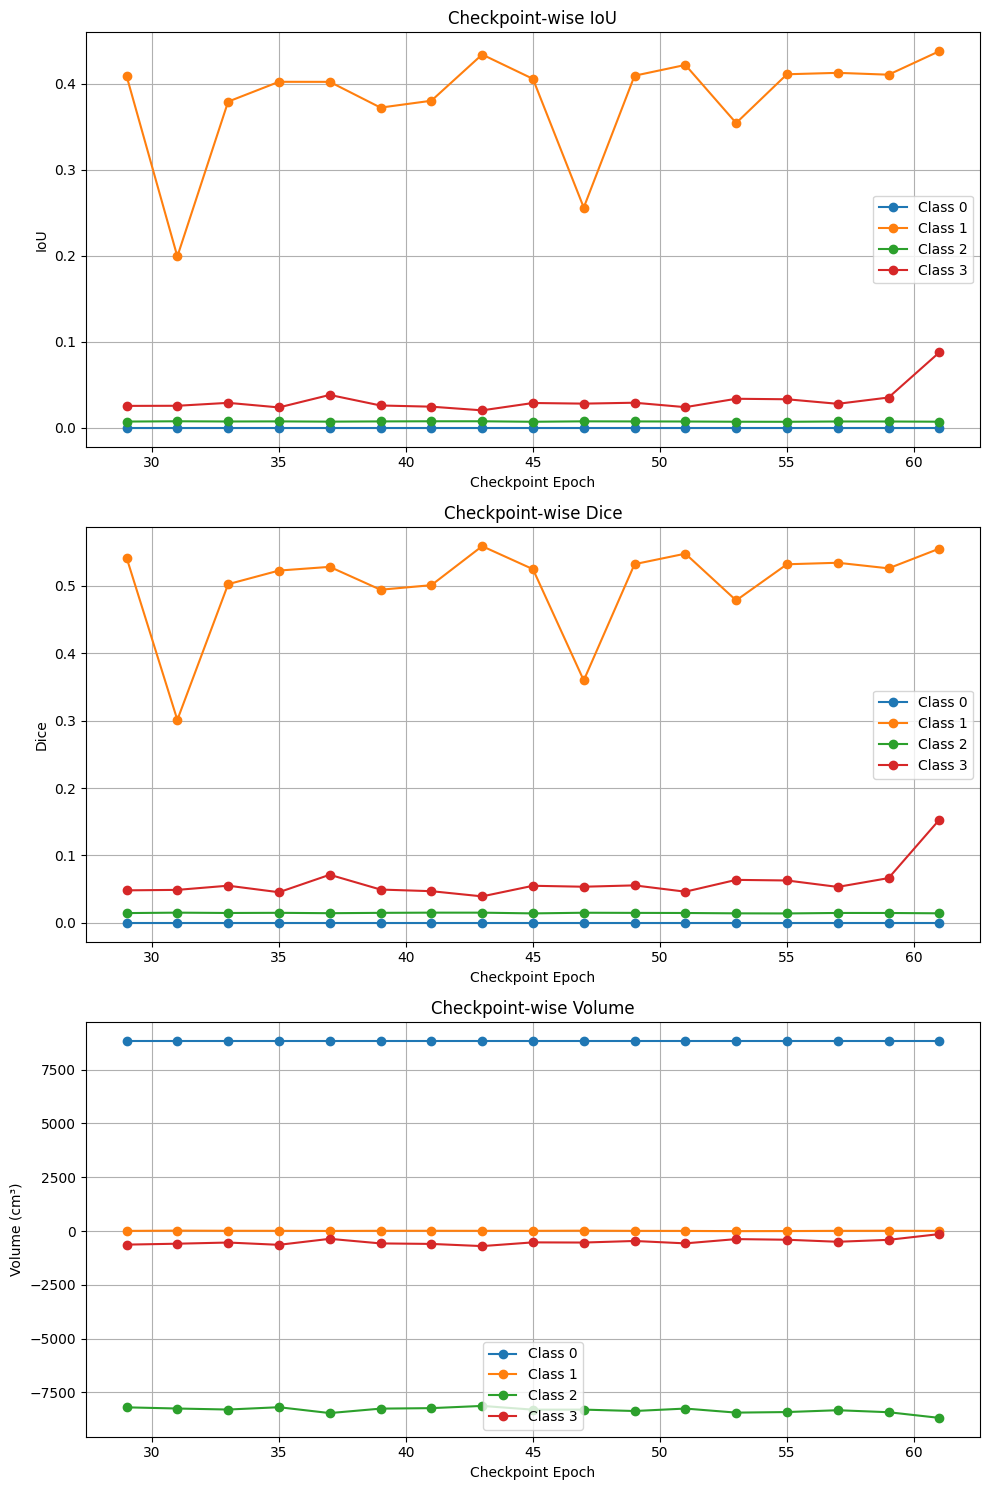

In [ ]:
import os
import matplotlib.pyplot as plt

# Prepare data for plotting
checkpoint_list = list(checkpoint_results.keys())
iou_values = {cls: [] for cls in range(4)}
dice_values = {cls: [] for cls in range(4)}
volume_values = {cls: [] for cls in range(4)}

# Collect average metrics for plotting
for epoch in checkpoint_list:
    for cls in range(4):
        iou_values[cls].append(checkpoint_results[epoch][cls]["IoU"])
        dice_values[cls].append(checkpoint_results[epoch][cls]["Dice"])
        volume_values[cls].append(checkpoint_results[epoch][cls]["Volume"])

# Plot IoU, Dice, and Volume for each class across checkpoints
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot IoU
for cls in range(4):
    axs[0].plot(checkpoint_list, iou_values[cls], label=f'Class {cls}', marker='o')  # added marker
axs[0].set_title("Checkpoint-wise IoU")
axs[0].set_xlabel("Checkpoint Epoch")
axs[0].set_ylabel("IoU")
axs[0].legend()
axs[0].grid(True)

# Plot Dice
for cls in range(4):
    axs[1].plot(checkpoint_list, dice_values[cls], label=f'Class {cls}', marker='o')  # added marker
axs[1].set_title("Checkpoint-wise Dice")
axs[1].set_xlabel("Checkpoint Epoch")
axs[1].set_ylabel("Dice")
axs[1].legend()
axs[1].grid(True)

# Plot Volume
for cls in range(4):
    axs[2].plot(checkpoint_list, volume_values[cls], label=f'Class {cls}', marker='o')  # added marker
axs[2].set_title("Checkpoint-wise Volume")
axs[2].set_xlabel("Checkpoint Epoch")
axs[2].set_ylabel("Volume (cm³)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()

# Save the plot
output_plot_dir = "plots/"
os.makedirs(output_plot_dir, exist_ok=True)  # Make directory if doesn't exist
plt.savefig(os.path.join(output_plot_dir, "per_checkpoint_with_markers.png"))
plt.show()

In [ ]:
# List all checkpoints you want to evaluate
checkpoint_epochs = list(range(29, 102, 2))  # [29, 31, 33, ..., 101]
checkpoint_epochs = [e for e in checkpoint_epochs if e % 2 != 0]  # Odd ones (29, 35, 41, ...)

for epoch in checkpoint_epochs:
    checkpoint_path = f"checkpoint_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_path):
        #print(f"Checkpoint {checkpoint_path} not found. Skipping...")
        print(f"\n\n==== Evaluating checkpoint: {checkpoint_path} ====\n")
    else:
        continue
    
    # Initialize model
    #model = UNet3D(in_channels=4, out_channels=4, final_sigmoid=False, use_glcm=True, use_se=True)
    #model = model.to(device)
       # Initialize model
    b_model = UNet3D(in_channels=4, out_channels=4, final_sigmoid=False)
    model = UNet3DWithSwinGatedFusion(
    base_unet3d=b_model,
    out_channels=4,
    swin_embed_dim=96
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    # Initialize metrics
    class_metrics = {cls: {"IoU": 0.0, "Dice": 0.0, "Volume": 0.0} for cls in range(0, 4)}
    class0, class1, class2, class3 = [], [], [], []

    with torch.no_grad():
        for idx, (images, label) in enumerate(test_loader):
            images = images.to(device)
            label = label.to(device)
            outputs = model(images)
            predicted_segmentation = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
            ground_truth_segmentation = label.cpu().numpy()

            metrics = calculate_metrics(predicted_segmentation, ground_truth_segmentation)

            voxel_volume_cm3 = 1 / 1000.0

            for cls in range(4):
                class_metrics[cls]["IoU"] += metrics[f"class_{cls}"]["IoU"]
                class_metrics[cls]["Dice"] += metrics[f"class_{cls}"]["Dice"]
                class_metrics[cls]["Volume"] += metrics[f"class_{cls}"]["Volume"] * voxel_volume_cm3

                # For individual sample Dice
                if cls == 0:
                    class0.append(metrics["class_0"]["Dice"])
                if cls == 1:
                    class1.append(metrics["class_1"]["Dice"])
                if cls == 2:
                    class2.append(metrics["class_2"]["Dice"])
                if cls == 3:
                    class3.append(metrics["class_3"]["Dice"])

            np.save(os.path.join(output_dir, f"segmented_{epoch}_{idx}.npy"), predicted_segmentation)

    # Average over all test samples
    for cls in range(4):
        class_metrics[cls]["IoU"] /= len(test_ids)
        class_metrics[cls]["Dice"] /= len(test_ids)
        class_metrics[cls]["Volume"] /= len(test_ids)

    print(f"==== Results for checkpoint {epoch} ====")
    for cls, values in class_metrics.items():
        print(f"Class {cls}: IoU = {values['IoU']:.4f}, Dice = {values['Dice']:.4f}, Avg Volume = {values['Volume']:.2f} voxels")




==== Evaluating checkpoint: checkpoint_epoch_29.pth ====



/tmp/ipykernel_10110/3723450740.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 2.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 2.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 2.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0 to 3.0
Label range: 0.0

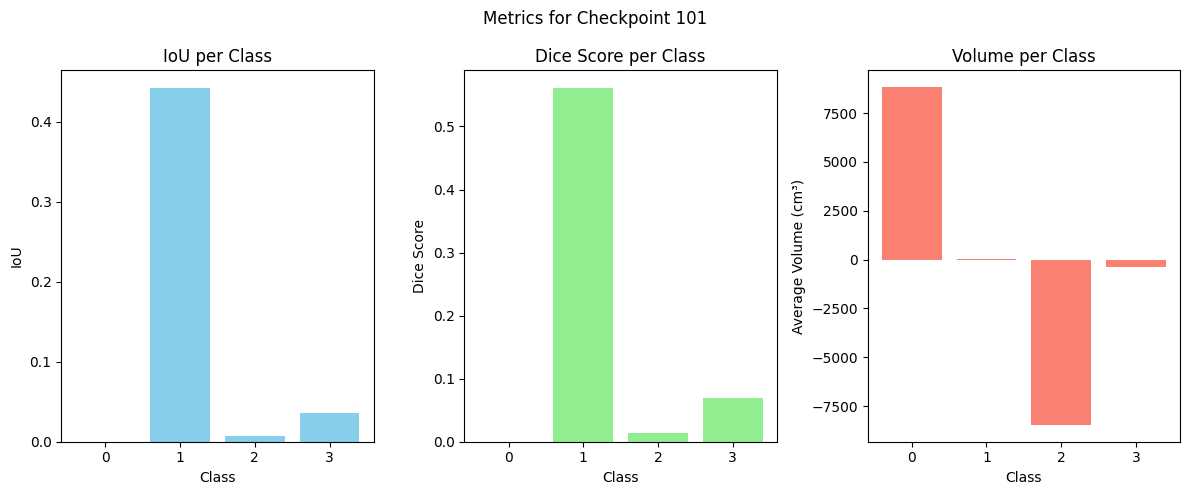

In [ ]:
import matplotlib.pyplot as plt
import os

# After your for-loop where you print the results

# Extract data for plotting
classes = list(class_metrics.keys())  # [0,1,2,3]
ious = [class_metrics[cls]["IoU"] for cls in classes]
dices = [class_metrics[cls]["Dice"] for cls in classes]
volumes = [class_metrics[cls]["Volume"] for cls in classes]

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.bar(classes, ious, color='skyblue')
plt.title('IoU per Class')
plt.xlabel('Class')
plt.ylabel('IoU')

plt.subplot(1, 3, 2)
plt.bar(classes, dices, color='lightgreen')
plt.title('Dice Score per Class')
plt.xlabel('Class')
plt.ylabel('Dice Score')

plt.subplot(1, 3, 3)
plt.bar(classes, volumes, color='salmon')
plt.title('Volume per Class')
plt.xlabel('Class')
plt.ylabel('Average Volume (cm³)')

plt.suptitle(f"Metrics for Checkpoint {epoch}")
plt.tight_layout()

# Save the plot
output_plot_dir = "plots/"
os.makedirs(output_plot_dir, exist_ok=True)  # Make directory if it doesn't exist
plt.savefig(os.path.join(output_plot_dir, f"checkpoint_{epoch}_metrics.png"))

plt.show()

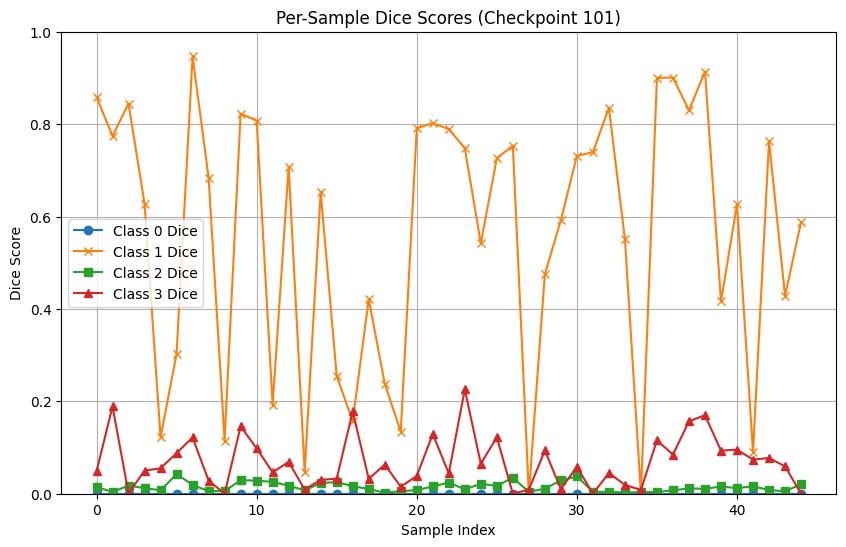

In [ ]:
# Sample indices (x-axis)
sample_indices = list(range(len(class0)))  # Assuming all classes have same number of samples

plt.figure(figsize=(10, 6))

plt.plot(sample_indices, class0, label='Class 0 Dice', marker='o')
plt.plot(sample_indices, class1, label='Class 1 Dice', marker='x')
plt.plot(sample_indices, class2, label='Class 2 Dice', marker='s')
plt.plot(sample_indices, class3, label='Class 3 Dice', marker='^')

plt.title(f"Per-Sample Dice Scores (Checkpoint {epoch})")
plt.xlabel('Sample Index')
plt.ylabel('Dice Score')
plt.ylim(0, 1)  # Dice scores range between 0 and 1
plt.legend()
plt.grid(True)

# Save the plot
output_plot_dir = "plots/"
os.makedirs(output_plot_dir, exist_ok=True)  # Make directory if doesn't exist
plt.savefig(os.path.join(output_plot_dir, f"per_sample_dice_checkpoint_{epoch}.png"))

plt.show()

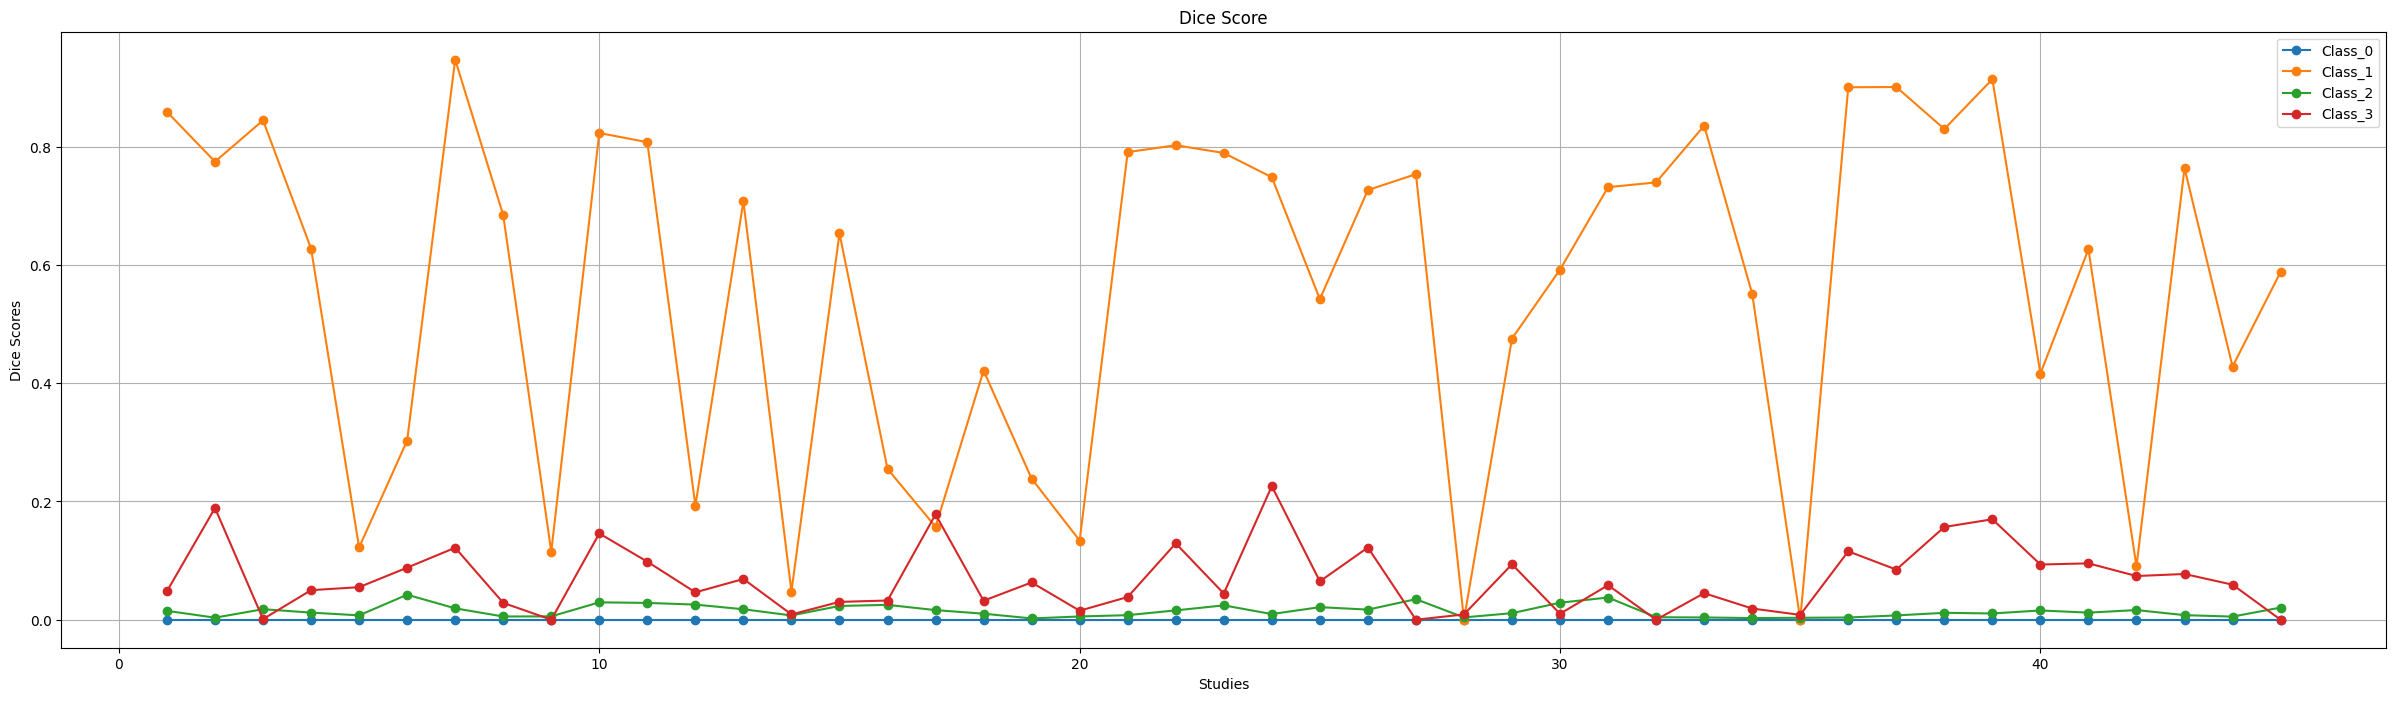

In [ ]:
study = range(1, len(class0) + 1)

# Plotting
plt.figure(figsize=(30, 8))
plt.plot(study, class0, label='Class_0', marker='o')
plt.plot(study, class1, label='Class_1', marker='o')
plt.plot(study, class2, label='Class_2', marker='o')
plt.plot(study, class3, label='Class_3', marker='o')

plt.title('Dice Score')
plt.xlabel('Studies')
plt.ylabel('Dice Scores')
plt.legend()
plt.grid(True)
plt.show()

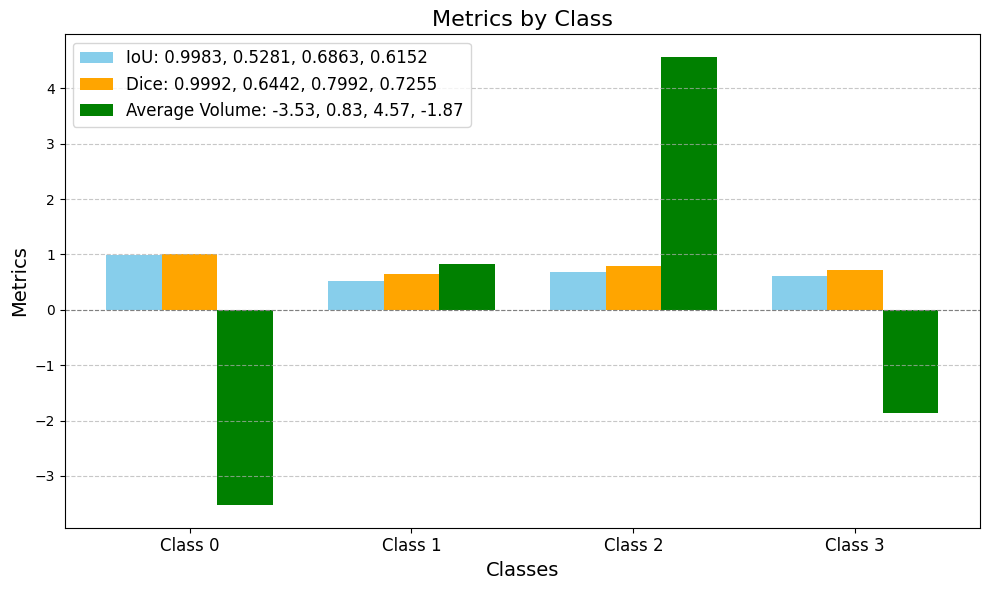

In [ ]:
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
iou = [0.9983, 0.5281, 0.6863, 0.6152]
dice = [0.9992, 0.6442, 0.7992, 0.7255]
avg_volume = [-3.53, 0.83, 4.57, -1.87]

# X-axis positions for grouped bars
x = np.arange(len(classes))  # Class indices
width = 0.25  # Width of each bar

# Plotting
plt.figure(figsize=(10, 6))

# Bars
plt.bar(x - width, iou, width, label='IoU: 0.9983, 0.5281, 0.6863, 0.6152', color='skyblue')
plt.bar(x, dice, width, label='Dice: 0.9992, 0.6442, 0.7992, 0.7255', color='orange')
plt.bar(x + width, avg_volume, width, label='Average Volume: -3.53, 0.83, 4.57, -1.87', color='green')

# Labels and title
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.title('Metrics by Class', fontsize=16)
plt.xticks(x, classes, fontsize=12)  # Add class labels to x-axis
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add horizontal line at y=0

# Legend
plt.legend(fontsize=12)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()